# Overview 

Using PINN to solve the inverse problem (obtaining $c(\omega$)). In this PINN, we are training solely NN2, which takes freq as the input and outputs phase velocity. 

The loss function only has two terms: Bessel v.s. data and the smoothness of the phase velocity

## [0] In terminal, create a conda env for the project

conda create -n Bessel python=3 <br>
conda activate Bessel <br>
conda install jupyter numpy matplotlib <br>
conda install pytorch torchvision torchaudio -c pytorch <br>

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.special as sp

# for computing the peak envelope
from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline

In [2]:
# set the path to your local PINNdata folder
localData = '/Users/xuebaobao/Desktop/Bessel/OpenCode/PINNdata/'

## [1] Network Setups

In [3]:
class NeuralNet1(nn.Module):
    def __init__(self, input_dimension, output_dimension,
                 n_hidden_layers, neurons, retrain_seed,
                 PV_median, PV_range=0.8):
        super().__init__()
        torch.manual_seed(retrain_seed)
        self.PV_median, self.PV_range = PV_median, PV_range
        self.activation = nn.Tanh()
        self.input_layer = nn.Linear(input_dimension, neurons)
        self.hidden_layers = nn.ModuleList(
            nn.Linear(neurons, neurons)
            for _ in range(n_hidden_layers-1)
        )
        self.output_layer = nn.Linear(neurons, output_dimension)
        # Xavier init
        def init_weights(m):
            if isinstance(m, nn.Linear):
                gain = nn.init.calculate_gain('tanh')
                nn.init.xavier_uniform_(m.weight, gain=gain)
                nn.init.zeros_(m.bias)
        self.apply(init_weights)
    
    def forward(self, x):
        # first layer + activation
        x = self.activation(self.input_layer(x))
        
        # hidden layers
        for lin in self.hidden_layers:
            x = self.activation(lin(x))
            
        # output
        x = self.output_layer(x)
        x = torch.tanh(x) * self.PV_range + self.PV_median
        return x

## [2] Compute Bessel (and other functions)

In [4]:
class GetBessel(torch.autograd.Function):
    @staticmethod
    def forward(ctx, n, x):
        # detach tensors explicitly to convert to numpy
        n_numpy = n.detach().cpu().numpy()
        x_numpy = x.detach().cpu().numpy()

        # compute using scipy explicitly (no grad tracking needed here)
        result_numpy = sp.jv(n_numpy, x_numpy)

        # save tensors explicitly for backward pass
        ctx.save_for_backward(n, x)

        # convert numpy results explicitly back to tensor
        result_tensor = torch.tensor(result_numpy, dtype=x.dtype, device=x.device)

        return result_tensor

    @staticmethod
    def backward(ctx, grad_output):
        n, x = ctx.saved_tensors

        # explicitly detach and convert for scipy (no grad tracking here)
        n_numpy = n.detach().cpu().numpy()
        x_numpy = x.detach().cpu().numpy()

        # compute derivative explicitly with scipy (standard bessel derivative identity)
        grad_x_numpy = (sp.jv(n_numpy - 1, x_numpy) - sp.jv(n_numpy + 1, x_numpy)) / 2

        # convert explicitly back to torch tensor
        grad_x = torch.tensor(grad_x_numpy, dtype=x.dtype, device=x.device)

        # propagate explicitly through grad_output
        grad_x = grad_output * grad_x

        # no gradient for order (n) since typically it’s an integer constant
        grad_n = None  

        return grad_n, grad_x


In [5]:
# Limit the range of phase velocity by the approximate upper and lower bounds proposed by Ekstrom et al. (2009)
def get_cw_median(input_f, RayWave):
    # input_f is a 2D tensor with size (N,1)
    
    cw_median = torch.from_numpy(input_f * -2.6 + 3.7).float().reshape(-1,1)

    if not RayWave:
        # for Love waves, increase the median by 0.5 km/s:
        cw_median = cw_median + 0.5

    return cw_median

In [6]:
# compute the envelope using Hilbert trasform 

import math
from scipy.fftpack import *

def hilbert_from_scratch(u):
    # N : fft length
    # M : number of elements to zero out
    # U : DFT of u
    # v : IDFT of H(U)

    N = len(u)
    # take forward Fourier transform
    U = fft(u)
    M = N - N//2 - 1
    # zero out negative frequency components
    U[N//2+1:] = [0] * M
    # double fft energy except @ DC0
    U[1:N//2] = 2 * U[1:N//2]
    # take inverse Fourier transform
    v = ifft(U)
    
    return v

In [7]:
# same as the smooth function in Matlab (need WSZ be odd number)
def smooth(a, WSZ):
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, must be an odd number
    
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    
    return np.concatenate((start, out0, stop))

## [3] Define Loss Functions

The loss function has several components: <br>
(1): the difference between NCF (observations) and NN2 output out_NCF <br>
(2): constrains the smoothness in c(f) (to avoid sudden changes in c(f))

In [8]:
# compute the total loss of the network
def compute_loss(out_PV, input_f, input_NCF, Lambdas, dist_r, RayWave):

    # define the weight of each loss term
    [lambda1, lambda2] = Lambdas

    # compute J0(x) using PV
    out_x = input_f * dist_r * 2 * np.pi / out_PV
    if RayWave:
        out_Bessel = GetBessel.apply(torch.tensor(0), out_x)
    else:
        out_Bessel = (GetBessel.apply(torch.tensor(0), out_x) - GetBessel.apply(torch.tensor(2), out_x))/2

    ### Loss1: observation (NCF) vs. J_0(x)
    loss1 = torch.mean((input_NCF - out_Bessel)**2)
    
    ### Loss2: constrain the smoothness of c(w)
    grad_out_PV = torch.autograd.grad(out_PV, input_f, grad_outputs=torch.ones_like(out_PV), create_graph=True)[0]
    grad_out_PV2 = torch.autograd.grad(grad_out_PV, input_f, grad_outputs=torch.ones_like(out_PV), create_graph=True)[0]
    loss2 = torch.mean(grad_out_PV2 ** 2)

    # add up to get the total loss
    loss = lambda1 * loss1 + lambda2 * loss2 
    
    # print(
    #     "Total loss: ", round(loss.item(), 4),
    #     "| Fitting Loss: ", round(loss1.item(), 4),
    #     "| Smooth Loss: ", round(loss2.item(), 4))
    
    return loss
    

## [4] Train the PINN

In [9]:
I_set_seed = 123

def train_PINN(input_f, noisyNCF, RayWave, Lambdas, dist_r, c_median, nnlayer, lr=float(1), nnneuoron=40):
   
    # Create PINN 
    approximate_PV = NeuralNet1(input_dimension=1, output_dimension=1, n_hidden_layers=nnlayer, neurons=nnneuoron, 
                            retrain_seed=I_set_seed, PV_median=c_median)
    
    # Define training parameters
    n_epochs = 1
    max_iter = 10000
    
    # to store the loss
    history = list()
    
    # define the optimizer
    optimizer_LBFGS = torch.optim.LBFGS(list(approximate_PV.parameters()),
                                  lr=lr,
                                  max_iter=max_iter,
                                  max_eval=50000,
                                  history_size=300,
                                  line_search_fn="strong_wolfe",
                                  tolerance_grad=1e-10,
                                  tolerance_change=1e-10)
    
    # Define a closure for the optimizer
    def closure():
        optimizer_LBFGS.zero_grad()
    
        # forward steps
        out_PV = approximate_PV(input_f)  # NN1 outputs phase velocity
        
        # compute the loss
        loss = compute_loss(out_PV, input_f, noisyNCF, Lambdas, dist_r, RayWave)

        history.append(loss.item())
        
        # backpropagate joint loss
        loss.backward()
    
        return loss
    
    for epoch in range(n_epochs):
        # print("################################ ", epoch, " ################################")
    
        # take optimizer step
        current_loss = optimizer_LBFGS.step(closure)

    # get the final inversion results
    infer_PV = approximate_PV(input_f)
    infer_x = input_f * dist_r * 2 * np.pi / infer_PV

    if RayWave:
        infer_Bessel = GetBessel.apply(torch.tensor(0), infer_x)
    else:
        infer_Bessel = (GetBessel.apply(torch.tensor(0), infer_x) - GetBessel.apply(torch.tensor(2), infer_x))/2

    return infer_PV, infer_Bessel, history, approximate_PV

In [10]:
# Read in all the Bessel envelopes
Bessel_envR = np.loadtxt(localData +'BesselEnveRay.csv', delimiter=',', skiprows=1)
Bessel_envL = np.loadtxt(localData +'BesselEnveLove.csv', delimiter=',', skiprows=1)

## [5] Exp1: XD-RUNG and XD-MTAN (w. uncer)

### [a] read in NCF data

In [11]:
# Input the station pair INFO
stapair = 'XD-RUNG_XD-MTAN'
stadist = 110

# read in NCF
dataLove = np.loadtxt(localData +'NCF/LoveResponse/dispersion_' + stapair + '.txt', 
                      delimiter=' ', skiprows=2)
NCF_f = dataLove[:,0]
Love_NCF = smooth(dataLove[:,1], 11)

dataRay = np.loadtxt(localData +'NCF/RayResponse/dispersion_' + stapair + '.txt', 
                      delimiter=' ', skiprows=2)
Ray_NCF = smooth(dataRay[:,1], 11)

# read in AkiEstimate Results
pred_f = []
pred_LPV = []
pred_LJ0 = []
with open(localData +'AkiEst/ResultOf03_04/Final_' + stapair + '/opt.pred-love', 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        pred_f.append(floats[0])
        pred_LPV.append(floats[2]/1000)
        pred_LJ0.append(floats[5])

pred_RPV = []
pred_RJ0 = []
with open(localData +'AkiEst/ResultOf03_04/Final_' + stapair + '/opt.pred-rayleigh', 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        pred_RPV.append(floats[2]/1000)
        pred_RJ0.append(floats[5])

IniPhase = localData +'AkiEst/InitialPhase_04/phase_' + stapair + '.love'
IP_Lf = []
IP_LPV = []
IP_Lpick = []
with open(IniPhase, 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        IP_Lf.append(floats[0])
        IP_LPV.append(floats[1])
        IP_Lpick.append(floats[2])

IniPhase = localData +'AkiEst/InitialPhase_04/phase_' + stapair + '.rayleigh'
IP_Rf = []
IP_RPV = []
IP_Rpick = []
with open(IniPhase, 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        IP_Rf.append(floats[0])
        IP_RPV.append(floats[1])
        IP_Rpick.append(floats[2])    

# read in the AkiEstimate PV uncertanity 
UncerPath = localData +'AkiEst/Uncer_04/Rayleigh_Uncer/Final_' + stapair + '.csv'
UncerRay = np.loadtxt(UncerPath, delimiter=',', dtype=float)
UncerPath = localData +'AkiEst/Uncer_04/Love_Uncer/Final_' + stapair + '.csv'
UncerLove = np.loadtxt(UncerPath, delimiter=',', dtype=float)

In [12]:
# find the best envelope to use 
rdists = np.append(np.linspace(60, 250, 20), [np.linspace(300, 1000, 15)])
iEnve = np.argmin(np.abs(rdists - stadist))
iBenvR = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_envR[:, iEnve])
iBenvL = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_envL[:, iEnve])

# Normalize the NCF by its Hilbert envelope
Love_HilbEnve = np.abs(hilbert_from_scratch(Love_NCF))
Ray_HilbEnve = np.abs(hilbert_from_scratch(Ray_NCF))

Love_NCFHilb = Love_NCF * (iBenvL / Love_HilbEnve)
Ray_NCFHilb = Ray_NCF * (iBenvR / Ray_HilbEnve)

(-0.5, 0.5)

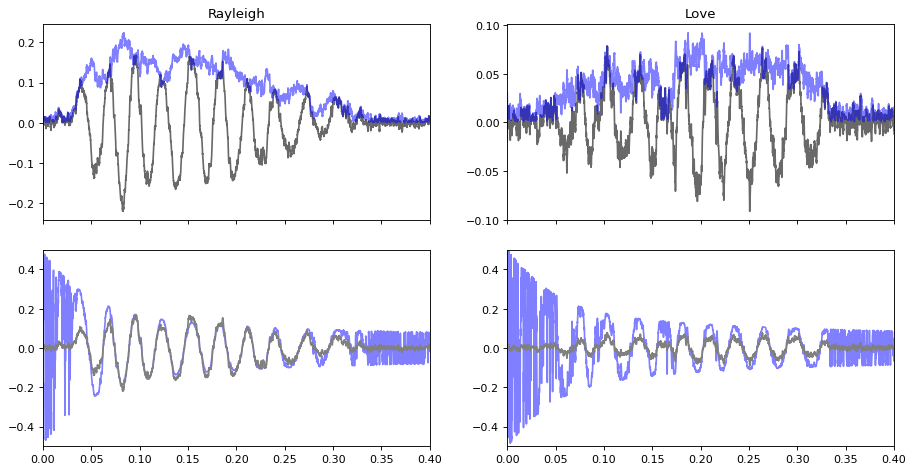

In [13]:
fig, axes = plt.subplots(2,2, figsize=(14, 6), dpi=80, sharex=True, 
                        gridspec_kw = dict( left = 0.18, right = 0.94, bottom = 0.1, top = 0.98, hspace = 0.15))

axes[0,0].plot(NCF_f, Ray_NCF, 'dimgray')
axes[0,0].plot(NCF_f, Ray_HilbEnve, 'b', alpha = 0.5)
axes[0,0].set_title('Rayleigh')
axes[0,0].set_xlim([0, 0.4])

axes[0,1].plot(NCF_f, Love_NCF, 'dimgray')
axes[0,1].plot(NCF_f, Love_HilbEnve, 'b', alpha = 0.5)
axes[0,1].set_title('Love')

axes[1,0].plot(NCF_f, Ray_NCFHilb, 'b', alpha = 0.5)
axes[1,0].plot(NCF_f, Ray_NCF, 'gray')
axes[1,0].set_ylim([-0.5, 0.5])

axes[1,1].plot(NCF_f, Love_NCFHilb, 'b', alpha = 0.5)
axes[1,1].plot(NCF_f, Love_NCF, 'gray')
axes[1,1].set_ylim([-0.5, 0.5])

### [b] train freq [0.025, 0.3]

In [14]:
nnlayer = 4
nnneuoron = 40

freqmax = 4500
freqmin = 359

#### [Rayleigh Wave] ####
RayWave = 1

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Ray_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Ray, infer_Bessel_Ray, history_Ray, Model_Ray = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)

#### [Love Wave] ####
RayWave = 0

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Love_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Love, infer_Bessel_Love, history_Love, Model_Love = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)


In [15]:
###### For plotting the really low Lambda2 case
#### [Rayleigh Wave] ####
RayWave = 1

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-20] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Ray_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Ray2, infer_Bessel_Ray2, history_Ray2, Model_Ray2 = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)

#### [Love Wave] ####
RayWave = 0

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-20] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Love_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Love2, infer_Bessel_Love2, history_Love2, Model_Love2 = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)


### [c] compute the Hessian to quantify the uncertanity

In [16]:
# Raw unscaled NN forward pass (for uncertainty only)
def manual_forward_unscaled(w_vector, nnModel, input_f):
    pointer = 0
    x = input_f

    in_w_shape = nnModel.input_layer.weight.shape
    in_b_shape = nnModel.input_layer.bias.shape
    num_in_w = in_w_shape.numel()
    num_in_b = in_b_shape.numel()

    in_w = w_vector[pointer:pointer+num_in_w].view(in_w_shape)
    pointer += num_in_w
    in_b = w_vector[pointer:pointer+num_in_b].view(in_b_shape)
    pointer += num_in_b

    x = nnModel.activation(torch.nn.functional.linear(x, in_w, in_b))

    for layer in nnModel.hidden_layers:
        layer_w_shape = layer.weight.shape
        layer_b_shape = layer.bias.shape
        num_w = layer_w_shape.numel()
        num_b = layer_b_shape.numel()

        layer_w = w_vector[pointer:pointer+num_w].view(layer_w_shape)
        pointer += num_w
        layer_b = w_vector[pointer:pointer+num_b].view(layer_b_shape)
        pointer += num_b

        x = nnModel.activation(torch.nn.functional.linear(x, layer_w, layer_b))

    out_w_shape = nnModel.output_layer.weight.shape
    out_b_shape = nnModel.output_layer.bias.shape
    num_out_w = out_w_shape.numel()
    num_out_b = out_b_shape.numel()

    out_w = w_vector[pointer:pointer+num_out_w].view(out_w_shape)
    pointer += num_out_w
    out_b = w_vector[pointer:pointer+num_out_b].view(out_b_shape)

    raw_output = torch.nn.functional.linear(x, out_w, out_b)
    return raw_output

# Explicit scaled forward pass for loss calculation
def manual_forward(w_vector, nnModel, input_f):
    raw_output = manual_forward_unscaled(w_vector, nnModel, input_f)
    scaled_output = torch.tanh(raw_output) * nnModel.PV_range + nnModel.PV_median
    return scaled_output

# fully explicit loss wrapper
def loss_fn(w_vector, nnModel, input_f, input_NCF, Lambdas, stadist, RayWave):
    out_PV = manual_forward(w_vector, nnModel, input_f)
    loss = compute_loss(out_PV, input_f, input_NCF, Lambdas, stadist, RayWave)
    return loss

#### Get the uncertanity for Love

In [17]:
# Uncertanity Experiment for Love Wave

RayWave = 0

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the ratio of two envelopes
input_NCF = torch.from_numpy(Love_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

with torch.no_grad():
    residual = input_NCF - infer_Bessel_Love
    noise_var = torch.mean(residual**2).item()   # σ_noise^2  (a scalar)
    print("data noise variance:", noise_var)

# get model parameters
w_star = nn.utils.parameters_to_vector(Model_Love.parameters()).detach().clone().requires_grad_(True)

# Check gradients explicitly before Hessian calculation
test_loss = loss_fn(w_star, Model_Love, input_f, input_NCF, Lambdas, stadist, RayWave)
test_grad = torch.autograd.grad(test_loss, w_star, retain_graph=True)[0]

print("Test Gradient (should be non-zero):", test_grad.max(), test_grad.min())


data noise variance: 0.008025413379073143
Test Gradient (should be non-zero): tensor(1.5410e-05) tensor(-1.5537e-05)


In [18]:
# Hessian calculation (explicitly)
hessian = torch.autograd.functional.hessian(
    lambda w: loss_fn(w, Model_Love, input_f, input_NCF, Lambdas, stadist, RayWave), w_star, create_graph=False)

hessian = 0.5 * (hessian + hessian.T)  # Symmetrise the Hessian before inversion

# Stabilize and invert Hessian explicitly
epsilon = 1e-4 * hessian.diag().abs().max()   # adapt to your problem scale

N=1
covariance_matrix = noise_var * torch.linalg.pinv(hessian * N + epsilon * torch.eye(hessian.shape[0]))
parameter_std = torch.sqrt(torch.clamp(torch.diagonal(covariance_matrix), min=0))

# explicitly compute raw output
raw_output = manual_forward_unscaled(w_star, Model_Love, input_f)

# explicitly compute the correct Jacobian at scaled output
tanh_derivative = Model_Love.PV_range * (1 - torch.tanh(raw_output)**2)
# PV_out = torch.tanh(raw_output) * Model_Love.PV_range + Model_Love.PV_median
# tanh_derivative = GetBessel.apply(torch.tensor(1), input_f * stadist * 2 * np.pi / PV_out) \
#             * 2 * np.pi * input_f * stadist * Model_Love.PV_range * (1 - torch.tanh(raw_output)**2) / PV_out**2

jacobian_raw = torch.autograd.functional.jacobian(
    lambda w: manual_forward_unscaled(w, Model_Love, input_f), w_star, create_graph=False).reshape(len(input_f), -1)

# scale jacobian explicitly with tanh derivative (chain rule)
jacobian = tanh_derivative * jacobian_raw


In [19]:
# Uncertainty propagation explicitly
output_covariance = jacobian @ covariance_matrix @ jacobian.T
output_variance = torch.clamp(torch.diagonal(output_covariance), min=0)
Love_std = torch.sqrt(output_variance)

print("Output std (uncertainty):", Love_std)

Output std (uncertainty): tensor([0.6111, 0.6108, 0.6105,  ..., 0.1579, 0.1581, 0.1583],
       grad_fn=<SqrtBackward0>)


#### Get the uncertanity for Rayleigh

In [20]:
# Uncertanity Experiment for Rayleigh Wave

RayWave = 1

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the ratio of two envelopes
input_NCF = torch.from_numpy(Ray_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

with torch.no_grad():
    residual = input_NCF - infer_Bessel_Ray
    noise_var = torch.mean(residual**2).item()   # σ_noise^2  (a scalar)
    print("data noise variance:", noise_var)

# get model parameters
w_star = nn.utils.parameters_to_vector(Model_Ray.parameters()).detach().clone().requires_grad_(True)

# Check gradients explicitly before Hessian calculation
test_loss = loss_fn(w_star, Model_Ray, input_f, input_NCF, Lambdas, stadist, RayWave)
test_grad = torch.autograd.grad(test_loss, w_star, retain_graph=True)[0]

print("Test Gradient (should be non-zero):", test_grad.max(), test_grad.min())


data noise variance: 0.0017884825356304646
Test Gradient (should be non-zero): tensor(1.1804e-05) tensor(-1.8195e-05)


In [21]:
# Hessian calculation (explicitly)
hessian = torch.autograd.functional.hessian(
    lambda w: loss_fn(w, Model_Ray, input_f, input_NCF, Lambdas, stadist, RayWave), w_star, create_graph=False)

hessian = 0.5 * (hessian + hessian.T)  # Symmetrise the Hessian before inversion

# Stabilize and invert Hessian explicitly
epsilon = 1e-4 * hessian.diag().abs().max()   # adapt to your problem scale

N=1
covariance_matrix = noise_var * torch.linalg.pinv(hessian * N + epsilon * torch.eye(hessian.shape[0]))
parameter_std = torch.sqrt(torch.clamp(torch.diagonal(covariance_matrix), min=0))

# explicitly compute raw output
raw_output = manual_forward_unscaled(w_star, Model_Ray, input_f)

# explicitly compute the correct Jacobian at scaled output
tanh_derivative = Model_Ray.PV_range * (1 - torch.tanh(raw_output)**2)
# PV_out = torch.tanh(raw_output) * Model_Ray.PV_range + Model_Ray.PV_median
# tanh_derivative = GetBessel.apply(torch.tensor(1), input_f * stadist * 2 * np.pi / PV_out) \
#             * 2 * np.pi * input_f * stadist * Model_Ray.PV_range * (1 - torch.tanh(raw_output)**2) / PV_out**2

jacobian_raw = torch.autograd.functional.jacobian(
    lambda w: manual_forward_unscaled(w, Model_Ray, input_f), w_star, create_graph=False).reshape(len(input_f), -1)

# scale jacobian explicitly with tanh derivative (chain rule)
jacobian = tanh_derivative * jacobian_raw


In [22]:
# Uncertainty propagation explicitly
output_covariance = jacobian @ covariance_matrix @ jacobian.T
output_variance = torch.clamp(torch.diagonal(output_covariance), min=0)
Ray_std = torch.sqrt(output_variance)

print("Output std (uncertainty):", Ray_std)

Output std (uncertainty): tensor([0.2288, 0.2288, 0.2289,  ..., 0.0567, 0.0567, 0.0568],
       grad_fn=<SqrtBackward0>)


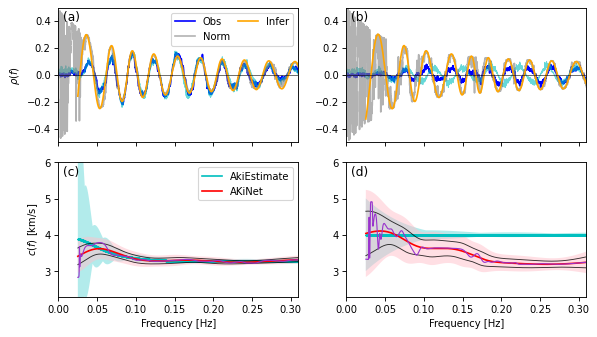

In [23]:
plot_f = input_f.detach().numpy()[:,0]

### Plot the obtained curves
matplotlib.rcParams.update({'font.size': 9})
fig, axes = plt.subplots(2,2, figsize=(7.5, 4.3), dpi=80, sharex=True, 
                        gridspec_kw = dict( left = 0.09, right = 0.97, bottom = 0.11, top = 0.95, hspace = 0.15))

# matplotlib.rcParams.update({'font.size': 14})
# fig, axes = plt.subplots(2,2, figsize=(14, 6), dpi=80, sharex=True, 
#                         gridspec_kw = dict( left = 0.18, right = 0.94, bottom = 0.1, top = 0.98, hspace = 0.15))

axes[0,0].plot(NCF_f, Ray_NCF, 'b', label='Obs')
axes[0,0].plot(pred_f, pred_RJ0, 'c', alpha = 0.6, linewidth=1)
axes[0,0].plot(NCF_f,  Ray_NCFHilb, 'gray', alpha = 0.6, label='Norm')
axes[0,0].plot(plot_f, infer_Bessel_Ray.detach().numpy()[:,0], 'orange', label='Infer')
axes[0,0].axhline(y = 0, linewidth = 0.5, color='k')
axes[0,0].set_ylabel(r'$\rho(f)$')
axes[0,0].legend(ncol=2, loc='upper right', columnspacing=0.85)
axes[0,0].text(0.006, 0.4, '(a)', fontsize=11, color='k')
axes[0,0].set_xlim([0, 0.31])
axes[0,0].set_ylim([-0.5, 0.5])

axes[0,1].plot(NCF_f, Love_NCF, 'b', label='Obs')
axes[0,1].plot(pred_f, pred_LJ0, 'c', alpha = 0.6, linewidth=1)
axes[0,1].plot(NCF_f,  Love_NCFHilb, 'gray', alpha = 0.6, label='Norm')
axes[0,1].plot(plot_f, infer_Bessel_Love.detach().numpy()[:,0], 'orange', label='Infer')
axes[0,1].axhline(y = 0, linewidth = 0.5, color='k')
axes[0,1].text(0.006, 0.4, '(b)', fontsize=11, color='k')
axes[0,1].set_ylim([-0.5, 0.5])

axes[1,0].plot(pred_f, pred_RPV, 'c.', markersize=1)
axes[1,0].plot([], [], 'c', linewidth=1.5, label='AkiEstimate')
axes[1,0].fill_between(UncerRay[:,0], UncerRay[:,1], UncerRay[:,2] ,alpha=0.3, facecolor='c')
axes[1,0].plot(plot_f, infer_PV_Ray.detach().numpy()[:,0], label='AKiNet', linewidth=1.5, color='red')
axes[1,0].fill_between(plot_f, infer_PV_Ray.detach().numpy()[:,0] + 1.96*Ray_std.detach().numpy(), 
                       infer_PV_Ray.detach().numpy()[:,0] - 1.96*Ray_std.detach().numpy(), alpha=0.5, facecolor='pink')
axes[1,0].plot(plot_f, infer_PV_Ray.detach().numpy()[:,0] + Ray_std.detach().numpy(), alpha=0.8, color='k', linewidth=0.8)
axes[1,0].plot(plot_f, infer_PV_Ray.detach().numpy()[:,0] - Ray_std.detach().numpy(), alpha=0.8, color='k', linewidth=0.8)
axes[1,0].plot(plot_f, infer_PV_Ray2.detach().numpy()[:,0], linewidth=1, color='darkorchid')
axes[1,0].text(0.006, 5.62, '(c)', fontsize=11, color='k')
axes[1,0].set_xlabel('Frequency [Hz]')
axes[1,0].set_ylabel(r'$c(f)$ [km/s]')
axes[1,0].set_ylim([2.3, 6])
axes[1,0].legend()

axes[1,1].plot(pred_f, pred_LPV, 'c.', label='AkiEstimate', markersize=1)
axes[1,1].fill_between(UncerLove[:,0], UncerLove[:,1], UncerLove[:,2] ,alpha=0.3, facecolor='c')
axes[1,1].plot(plot_f, infer_PV_Love.detach().numpy()[:,0], label='AKiNet', linewidth=1.5, color='red')
axes[1,1].fill_between(plot_f, infer_PV_Love.detach().numpy()[:,0] + 1.96*Love_std.detach().numpy(), 
                       infer_PV_Love.detach().numpy()[:,0] - 1.96*Love_std.detach().numpy(), alpha=0.5, facecolor='pink')
axes[1,1].plot(plot_f, infer_PV_Love.detach().numpy()[:,0] + Love_std.detach().numpy(), alpha=0.8, color='k', linewidth=0.8)
axes[1,1].plot(plot_f, infer_PV_Love.detach().numpy()[:,0] - Love_std.detach().numpy(), alpha=0.8, color='k', linewidth=0.8)
axes[1,1].plot(plot_f, infer_PV_Love2.detach().numpy()[:,0], linewidth=1, color='darkorchid')
axes[1,1].text(0.006, 5.62, '(d)', fontsize=11, color='k')
axes[1,1].set_xlabel('Frequency [Hz]')
axes[1,1].set_ylim([2.3, 6]);

# plt.savefig( './Figures/S4_Uncer1.pdf', dpi = 400, facecolor = 'w' )

## [5] Exp5: 2H-ASYE and 7C-GOR (w. uncer)

### [a] read in the data

In [24]:
# Input station pair INFO

stapair = '2H-ASYE_7C-GOR'
stadist = 90

# Read in NCF
dataLove = np.loadtxt(localData + 'NCF/LoveResponse/dispersion_' + stapair + '.txt', 
                      delimiter=' ', skiprows=2)
NCF_f = dataLove[:,0]
Love_NCF = smooth(dataLove[:,1], 11)

dataRay = np.loadtxt(localData + 'NCF/RayResponse/dispersion_' + stapair + '.txt', 
                      delimiter=' ', skiprows=2)
Ray_NCF = smooth(dataRay[:,1], 11)

# read in AkiEstimate Results
pred_f = []
pred_LPV = []
pred_LJ0 = []
pred_LHilb = []
with open(localData + 'AkiEst/ResultOf03_04/Final_' + stapair + '/opt.pred-love', 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        pred_f.append(floats[0])
        pred_LPV.append(floats[2]/1000)
        pred_LHilb.append(floats[4])
        pred_LJ0.append(floats[5])

pred_RPV = []
pred_RJ0 = []
with open(localData + 'AkiEst/ResultOf03_04/Final_' + stapair + '/opt.pred-rayleigh', 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        pred_RPV.append(floats[2]/1000)
        pred_RJ0.append(floats[5])

IniPhase = localData + 'AkiEst/InitialPhase_04/phase_' + stapair + '.love'
IP_Lf = []
IP_LPV = []
IP_Lpick = []
with open(IniPhase, 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        IP_Lf.append(floats[0])
        IP_LPV.append(floats[1])
        IP_Lpick.append(floats[2])

IniPhase = localData + 'AkiEst/InitialPhase_04/phase_' + stapair + '.rayleigh'
IP_Rf = []
IP_RPV = []
IP_Rpick = []
with open(IniPhase, 'r') as f:
    for line in f:
        # Split on whitespace
        tokens = line.split()
        
        # Convert each token to float
        floats = [float(tok) for tok in tokens]
        IP_Rf.append(floats[0])
        IP_RPV.append(floats[1])
        IP_Rpick.append(floats[2])    

# read in the AkiEstimate PV uncertanity 
UncerPath = localData + 'AkiEst/Uncer_04/Rayleigh_Uncer/Final_' + stapair + '.csv'
UncerRay = np.loadtxt(UncerPath, delimiter=',', dtype=float)
UncerPath = localData + 'AkiEst/Uncer_04/Love_Uncer/Final_' + stapair + '.csv'
UncerLove = np.loadtxt(UncerPath, delimiter=',', dtype=float)

In [25]:
# find the best envelope to use 
rdists = np.append(np.linspace(60, 250, 20), [np.linspace(300, 1000, 15)])
iEnve = np.argmin(np.abs(rdists - stadist))
iBenvR = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_envR[:, iEnve])
iBenvL = np.interp(NCF_f, np.linspace(0,0.5,1000), Bessel_envL[:, iEnve])

# Normalize the NCF by its Hilbert envelope
Love_HilbEnve = np.abs(hilbert_from_scratch(Love_NCF))
Ray_HilbEnve = np.abs(hilbert_from_scratch(Ray_NCF))

Love_NCFHilb = Love_NCF * (iBenvL / Love_HilbEnve)
Ray_NCFHilb = Ray_NCF * (iBenvR / Ray_HilbEnve)

(-0.5, 0.5)

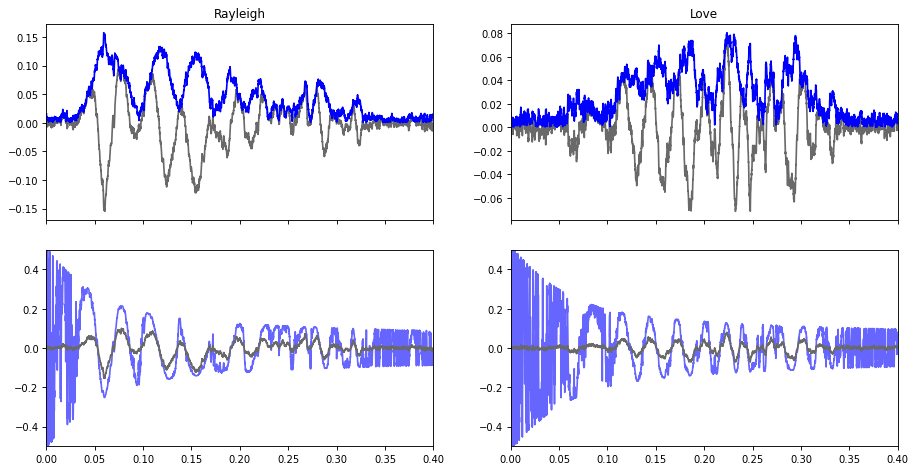

In [26]:
fig, axes = plt.subplots(2,2, figsize=(14, 6), dpi=80, sharex=True, 
                        gridspec_kw = dict( left = 0.18, right = 0.94, bottom = 0.1, top = 0.98, hspace = 0.15))

axes[0,0].plot(NCF_f, Ray_NCF, 'dimgray')
axes[0,0].plot(NCF_f, Ray_HilbEnve, 'b')
axes[0,0].set_title('Rayleigh')
axes[0,0].set_xlim([0, 0.4])

axes[0,1].plot(NCF_f, Love_NCF, 'dimgray')
axes[0,1].plot(NCF_f, Love_HilbEnve, 'b')
axes[0,1].set_title('Love')

axes[1,0].plot(NCF_f, Ray_NCFHilb, 'b', alpha = 0.6)
axes[1,0].plot(NCF_f, Ray_NCF, 'dimgray')
axes[1,0].set_ylim([-0.5, 0.5])

axes[1,1].plot(NCF_f, Love_NCFHilb, 'b', alpha = 0.6)
axes[1,1].plot(NCF_f, Love_NCF, 'dimgray')
axes[1,1].set_ylim([-0.5, 0.5])

### [b] train the PINN

In [27]:
nnlayer = 4
nnneuoron = 40

freqmax = 4500
freqmin = 359

#### [Rayleigh Wave] ####
RayWave = 1

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Ray_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Ray, infer_Bessel_Ray, history_Ray, Model_Ray = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)

#### [Love Wave] ####
RayWave = 0

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Love_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Love, infer_Bessel_Love, history_Love, Model_Love = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)


In [28]:
###### For plotting the really low Lambda2 case
#### [Rayleigh Wave] ####
RayWave = 1

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-20] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Ray_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Ray2, infer_Bessel_Ray2, history_Ray2, Model_Ray2 = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)

#### [Love Wave] ####
RayWave = 0

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-20] # weight for different loss terms

# get the median to set the range of possible phase velocity
c_median = get_cw_median(NCF_f, RayWave)[freqmin:freqmax]

input_NCF = torch.from_numpy(Love_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# train the PINN
infer_PV_Love2, infer_Bessel_Love2, history_Love2, Model_Love2 = train_PINN(input_f, input_NCF, RayWave, 
                                                      Lambdas, stadist, c_median, nnlayer, float(1), nnneuoron)


### [c] compute the Hessian to quantify the uncertanity

In [30]:
# Uncertanity Experiment for Love Wave

RayWave = 0

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the ratio of two envelopes
input_NCF = torch.from_numpy(Love_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# get model parameters
w_star = nn.utils.parameters_to_vector(Model_Love.parameters()).detach().clone().requires_grad_(True)

with torch.no_grad():
    residual = input_NCF - infer_Bessel_Love
    noise_var = torch.mean(residual**2).item()   # σ_noise^2  (a scalar)
    print("data noise variance:", noise_var)


data noise variance: 0.011038990691304207


In [31]:
# Hessian calculation (explicitly)
hessian = torch.autograd.functional.hessian(
    lambda w: loss_fn(w, Model_Love, input_f, input_NCF, Lambdas, stadist, RayWave), w_star, create_graph=False)

hessian = 0.5 * (hessian + hessian.T)  # Symmetrise the Hessian before inversion

# Stabilize and invert Hessian explicitly
epsilon = 1e-4 * hessian.diag().abs().max()   # adapt to your problem scale

# N = input_NCF.shape[0]  # number of points explicitly
N = 1
covariance_matrix = noise_var * torch.linalg.pinv(hessian * N + epsilon * torch.eye(hessian.shape[0]))

# explicitly compute raw output
raw_output = manual_forward_unscaled(w_star, Model_Love, input_f)

# explicitly compute the correct Jacobian at scaled output
tanh_derivative = Model_Love.PV_range * (1 - torch.tanh(raw_output)**2)

jacobian_raw = torch.autograd.functional.jacobian(
    lambda w: manual_forward_unscaled(w, Model_Love, input_f), w_star, create_graph=False).reshape(len(input_f), -1)

# scale jacobian explicitly with tanh derivative (chain rule)
jacobian = tanh_derivative * jacobian_raw


In [32]:
# Uncertainty propagation explicitly
output_covariance = jacobian @ covariance_matrix @ jacobian.T
output_variance = torch.clamp(torch.diagonal(output_covariance), min=0)
Love_std = torch.sqrt(output_variance)

print("Output std (uncertainty):", Love_std)

Output std (uncertainty): tensor([1.0564, 1.0546, 1.0528,  ..., 0.2085, 0.2087, 0.2089],
       grad_fn=<SqrtBackward0>)


In [33]:
# Uncertanity Experiment for Rayleigh Wave

RayWave = 1

# set the hyperparameters for the loss function
Lambdas = [1e0, 1e-8] # weight for different loss terms

# get the ratio of two envelopes
input_NCF = torch.from_numpy(Ray_NCFHilb[freqmin:freqmax]).float().reshape(-1,1)
input_NCF.requires_grad = True

# set the input_f so that can compute the gradient of PV in the loss function
input_f = torch.from_numpy(NCF_f[freqmin:freqmax]).float().reshape(-1,1)
input_f.requires_grad = True
input_f.allow_unused = True

# get model parameters
w_star = nn.utils.parameters_to_vector(Model_Ray.parameters()).detach().clone().requires_grad_(True)

with torch.no_grad():
    residual = input_NCF - infer_Bessel_Ray
    noise_var = torch.mean(residual**2).item()   # σ_noise^2  (a scalar)
    print("data noise variance:", noise_var)


data noise variance: 0.005459285341203213


In [34]:
# Hessian calculation (explicitly)
hessian = torch.autograd.functional.hessian(
    lambda w: loss_fn(w, Model_Ray, input_f, input_NCF, Lambdas, stadist, RayWave), w_star, create_graph=False)

hessian = 0.5 * (hessian + hessian.T)  # Symmetrise the Hessian before inversion

# Stabilize and invert Hessian explicitly
epsilon = 1e-4 * hessian.diag().abs().max()   # adapt to your problem scale

# N = input_NCF.shape[0]  # number of points explicitly
N = 1
covariance_matrix = noise_var * torch.linalg.pinv(hessian * N + epsilon * torch.eye(hessian.shape[0]))

# explicitly compute raw output
raw_output = manual_forward_unscaled(w_star, Model_Ray, input_f)

# explicitly compute the correct Jacobian at scaled output
tanh_derivative = Model_Ray.PV_range * (1 - torch.tanh(raw_output)**2)

jacobian_raw = torch.autograd.functional.jacobian(
    lambda w: manual_forward_unscaled(w, Model_Ray, input_f), w_star, create_graph=False).reshape(len(input_f), -1)

# scale jacobian explicitly with tanh derivative (chain rule)
jacobian = tanh_derivative * jacobian_raw


In [35]:
# Uncertainty propagation explicitly
output_covariance = jacobian_raw @ covariance_matrix @ jacobian_raw.T
output_variance = torch.clamp(torch.diagonal(output_covariance), min=0)
Ray_std = torch.sqrt(output_variance)

print("Output std (uncertainty):", Ray_std)

Output std (uncertainty): tensor([0.6448, 0.6438, 0.6427,  ..., 0.1969, 0.1971, 0.1973])


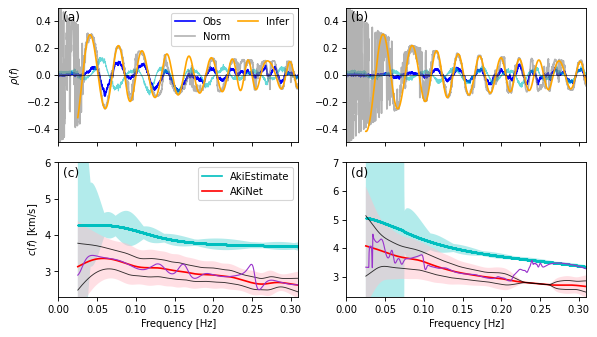

In [36]:
plot_f = input_f.detach().numpy()[:,0]

### Plot the obtained curves
matplotlib.rcParams.update({'font.size': 9})
fig, axes = plt.subplots(2,2, figsize=(7.5, 4.3), dpi=80, sharex=True, 
                        gridspec_kw = dict( left = 0.09, right = 0.97, bottom = 0.11, top = 0.95, hspace = 0.15))

# matplotlib.rcParams.update({'font.size': 14})
# fig, axes = plt.subplots(2,2, figsize=(14, 6), dpi=80, sharex=True, 
#                         gridspec_kw = dict( left = 0.18, right = 0.94, bottom = 0.1, top = 0.98, hspace = 0.15))

axes[0,0].plot(NCF_f, Ray_NCF, 'b', label='Obs')
axes[0,0].plot(pred_f, pred_RJ0, 'c', alpha = 0.6, linewidth=1)
axes[0,0].plot(NCF_f,  Ray_NCFHilb, 'gray', alpha = 0.6, label='Norm')
axes[0,0].plot(plot_f, infer_Bessel_Ray.detach().numpy()[:,0], 'orange', label='Infer')
axes[0,0].axhline(y = 0, linewidth = 0.5, color='k')
axes[0,0].set_ylabel(r'$\rho(f)$')
axes[0,0].legend(ncol=2, loc='upper right', columnspacing=0.85)
axes[0,0].text(0.006, 0.4, '(a)', fontsize=11, color='k')
axes[0,0].set_xlim([0, 0.31])
axes[0,0].set_ylim([-0.5, 0.5])

axes[0,1].plot(NCF_f, Love_NCF, 'b', label='Obs')
axes[0,1].plot(pred_f, pred_LJ0, 'c', alpha = 0.6, linewidth=1)
axes[0,1].plot(NCF_f,  Love_NCFHilb, 'gray', alpha = 0.6, label='Norm')
axes[0,1].plot(plot_f, infer_Bessel_Love.detach().numpy()[:,0], 'orange', label='Infer')
axes[0,1].axhline(y = 0, linewidth = 0.5, color='k')
axes[0,1].text(0.006, 0.4, '(b)', fontsize=11, color='k')
axes[0,1].set_ylim([-0.5, 0.5])

axes[1,0].plot(pred_f, pred_RPV, 'c.', markersize=1)
axes[1,0].plot([], [], 'c', linewidth=1.5, label='AkiEstimate')
axes[1,0].fill_between(UncerRay[:,0], UncerRay[:,1], UncerRay[:,2] ,alpha=0.3, facecolor='c')
axes[1,0].plot(plot_f, infer_PV_Ray.detach().numpy()[:,0], label='AKiNet', linewidth=1.5, color='red')
axes[1,0].fill_between(plot_f, infer_PV_Ray.detach().numpy()[:,0] + 1.96*Ray_std.detach().numpy(), 
                       infer_PV_Ray.detach().numpy()[:,0] - 1.96*Ray_std.detach().numpy(), alpha=0.5, facecolor='pink')
axes[1,0].plot(plot_f, infer_PV_Ray.detach().numpy()[:,0] + Ray_std.detach().numpy(), alpha=0.8, color='k', linewidth=0.8)
axes[1,0].plot(plot_f, infer_PV_Ray.detach().numpy()[:,0] - Ray_std.detach().numpy(), alpha=0.8, color='k', linewidth=0.8)
axes[1,0].plot(plot_f, infer_PV_Ray2.detach().numpy()[:,0], linewidth=1, color='darkorchid')
axes[1,0].text(0.006, 5.6, '(c)', fontsize=11, color='k')
axes[1,0].set_xlabel('Frequency [Hz]')
axes[1,0].set_ylabel(r'$c(f)$ [km/s]')
axes[1,0].set_ylim([2.3, 6])
axes[1,0].legend()

axes[1,1].plot(pred_f, pred_LPV, 'c.', label='AkiEstimate', markersize=1)
axes[1,1].fill_between(UncerLove[:,0], UncerLove[:,1], UncerLove[:,2] ,alpha=0.3, facecolor='c')
axes[1,1].plot(plot_f, infer_PV_Love.detach().numpy()[:,0], label='AKiNet', linewidth=1.5, color='red')
axes[1,1].fill_between(plot_f, infer_PV_Love.detach().numpy()[:,0] + 1.96*Love_std.detach().numpy(), 
                       infer_PV_Love.detach().numpy()[:,0] - 1.96*Love_std.detach().numpy(), alpha=0.5, facecolor='pink')
axes[1,1].plot(plot_f, infer_PV_Love.detach().numpy()[:,0] + Love_std.detach().numpy(), alpha=0.8, color='k', linewidth=0.8)
axes[1,1].plot(plot_f, infer_PV_Love.detach().numpy()[:,0] - Love_std.detach().numpy(), alpha=0.8, color='k', linewidth=0.8)
axes[1,1].plot(plot_f, infer_PV_Love2.detach().numpy()[:,0], linewidth=1, color='darkorchid')
axes[1,1].text(0.006, 6.5, '(d)', fontsize=11, color='k')
axes[1,1].set_xlabel('Frequency [Hz]')
axes[1,1].set_ylim([2.3, 7]);

# plt.savefig( './Figures/S5_Uncer2.pdf', dpi = 400, facecolor = 'w' )